# Реализация линейного классификатора с логистической функцией потерь.

Здесь представлена реализация линейного классификатора с логистической функцией потерь. Эксперименты проводятся на датасете, содержащем комментарии из раздела обсуждений английской Википедии. Задача заключается в определении: является ли данный комментарий токсичным или нет (подробности здесь: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

In [1]:
import numpy as np
import math
import scipy
from scipy.special import expit, logit
from scipy import linalg
import random
import scipy as sc
from scipy.sparse import csr_matrix
from timeit import default_timer as timer
import pandas as pd

In [47]:
class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, l2_coef):
        self.l2_coef = l2_coef
     
    def func(self, X, y, w):
        array_sigmoid = expit(X.dot(w) * y)
        return (-sum(np.log(array_sigmoid)) / len(y) + self.l2_coef *
                linalg.norm(w, 2)**2 / 2)
        
    def grad(self, X, y, w):
        array_sigmoid = expit(-X.dot(w) * y)
        return self.l2_coef * w - X.T.dot(array_sigmoid * y) / len(y)


In [48]:
class GDClassifier:
    def __init__(self, loss_function, step_alpha=1, step_beta=0,
                 tolerance=1e-5, max_iter=1000, **kwargs):
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.keys = list(kwargs.keys())
        if 'l2_coef' in self.keys:
            self.l2_coef = kwargs['l2_coef']
        else:
            self.l2_coef = 0
        self.func_loss = BinaryLogistic(self.l2_coef)
        self.w = np.array([])

    def fit(self, X, y, w_0=None, trace=False):
        history = {'time': [], 'func': []}
        if self.loss_function == 'binary_logistic':
            self.w = w_0.copy()
            if trace:
                history['time'].append(0)
                history['func'].append(self.func_loss.func(X, y, self.w))
            for k in range(1, self.max_iter + 1):
                start = timer()
                prev_func = self.func_loss.func(X, y, self.w)
                self.w = (self.w - self.step_alpha *
                             self.func_loss.grad(X, y, self.w) / k**self.step_beta)
                current_func = self.func_loss.func(X, y, self.w)
                if (math.fabs(current_func -
                              prev_func) < self.tolerance):
                    end = timer()
                    dif = end - start
                    if trace:
                        history['time'].append(dif)
                        history['func'].append(current_func)
                    break
                end = timer()
                dif = end - start
                if trace:
                    history['time'].append(dif)
                    history['func'].append(current_func)
        if trace:
            return history
        return None

    def predict(self, X):
        label = X.dot(self.w)
        return np.sign(label)
    def predict_proba(self, X):
        array_1 = expit(X.dot(self.w))
        array_2 = expit(-X.dot(self.w))
        prob = np.array([array_1, array_2]).T
        return prob

    def get_objective(self, X, y):
        if self.loss_function == 'binary_logistic':
            return self.func_loss.func(X, y, self.w)
        else:
            print("Wrong function!")

    def get_gradient(self, X, y):
        if self.loss_function == 'binary_logistic':
            return self.func_loss.grad(X, y, self.w)
        else:
            print("Wrong function!")

    def get_weights(self):
        return self.w


# Преобразование данных

In [5]:
comment = pd.read_csv('toxic_train.csv')

In [6]:
comment['comment_text'] = comment['comment_text'].str.replace("[^a-zA-Z0-9#]", " ")
comment['comment_text'] = comment['comment_text'].apply(lambda x: x.lower())

<ipython-input-6-edf6364902c4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  comment['comment_text'] = comment['comment_text'].str.replace("[^a-zA-Z0-9#]", " ")


In [7]:
comment.head()

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.4)
X = csr_matrix(vectorizer.fit_transform(comment['comment_text']))

In [8]:
comment.loc[comment['is_toxic'] == True, 'is_toxic'] = 1

In [9]:
comment.loc[comment['is_toxic'] == False, 'is_toxic'] = -1

In [10]:
comment.head()

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,-1
1,1,d aww he matches this background colour i m s...,-1
2,2,hey man i m really not trying to edit war it...,-1
3,3,more i can t make any real suggestions on im...,-1
4,4,you sir are my hero any chance you remember...,-1


In [11]:
y = np.array(comment['is_toxic'], dtype='int')

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

In [13]:
from sklearn.metrics import accuracy_score

# Эксперименты

## Зависимость функции потерь от итерации метода

In [49]:
time = []
history = []
accuracy = []
values = []
alpha = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 0.7]
for i in range(len(alpha)):
    start = timer()
    gd = GDClassifier('binary_logistic', step_alpha=alpha[i], step_beta=0,
                 tolerance=1e-5, max_iter=1000, l2_coef=0.1)
    values = gd.fit(X, y, w_0=np.random.normal(0, 0.1, X.shape[1]), trace=True)
    end = timer()
    dif = end - start
    time.append(dif)
    accuracy.append(accuracy_score(np.array(y), gd.predict(X)))
    history.append(values)

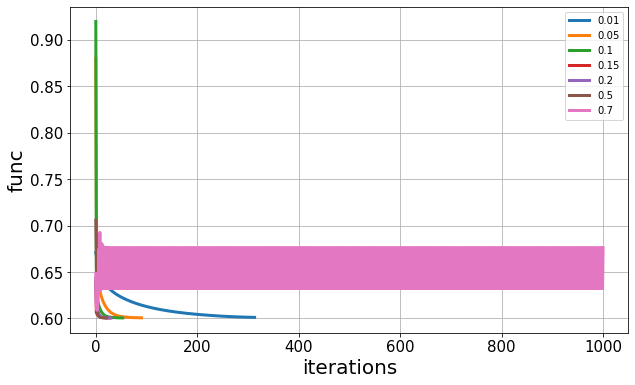

In [50]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(alpha)):
    plt.plot(history[i]['func'], linewidth=3, label=alpha[i])
plt.xlabel('iterations',fontsize=20)
plt.ylabel('func', fontsize=20)
plt.legend(loc='best')

Тот же самый график без последнего шага $alpha[6]=0.7$

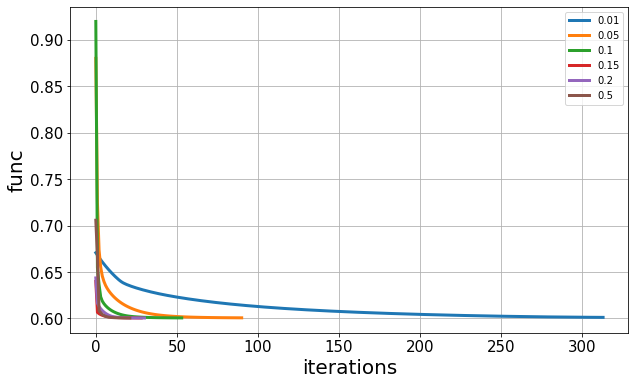

In [51]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(alpha)-1):
    plt.plot(history[i]['func'], linewidth=3, label=alpha[i])
plt.xlabel('iterations',fontsize=20)
plt.ylabel('func', fontsize=20)
plt.legend(loc='best')

При увеличении шага до $0.5$ градиентный спуск сходится быстрее, при увеличении до $0.7$ сходимости уже нет.

## Зависимость функции потерь от времени работы метода

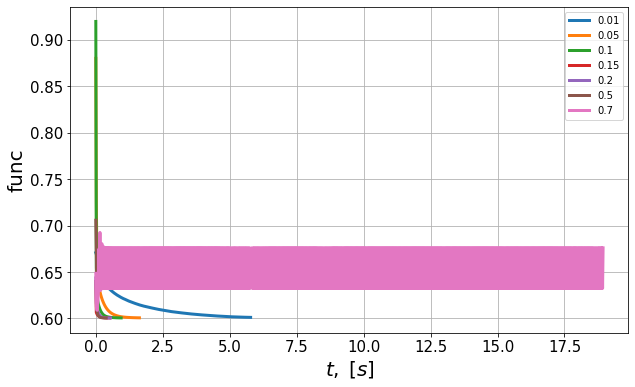

In [91]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(alpha)):
    T = []
    length = len(history[i]['time'])
    for j in range(length):
        T.append(sum(history[i]['time'][:j+1]))
    plt.plot(T, history[i]['func'], linewidth=3, label=alpha[i])
    plt.xlabel(r'$t,\;[s]$',fontsize=20)
    plt.ylabel('func', fontsize=20)
    plt.legend(loc='best')

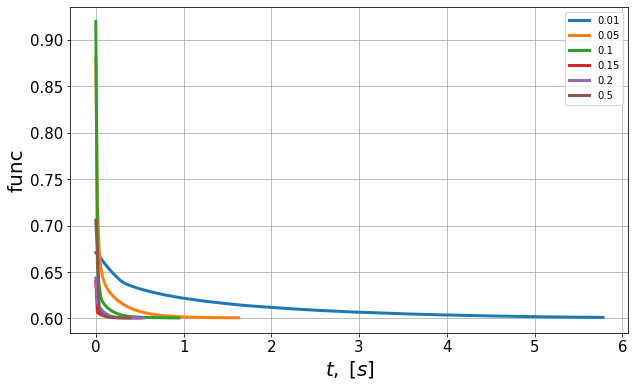

In [92]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(alpha)-1):
    T = []
    length = len(history[i]['time'])
    for j in range(length):
        T.append(sum(history[i]['time'][:j+1]))
    plt.plot(T, history[i]['func'], linewidth=3, label=alpha[i])
    plt.xlabel(r'$t,\;[s]$',fontsize=20)
    plt.ylabel('func', fontsize=20)
    plt.legend(loc='best')

## Значения функции потерь от времени работы метода при разных $alpha$

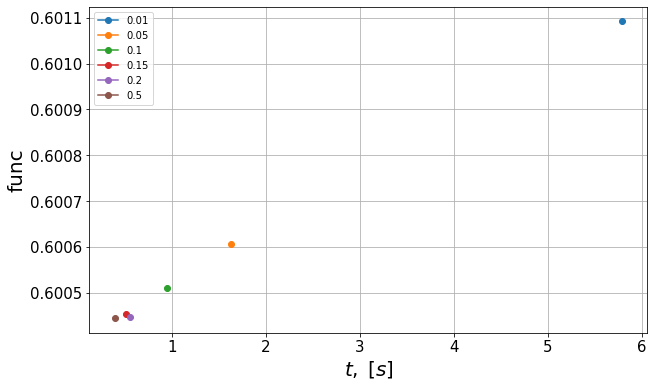

In [88]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(alpha)-1):
    plt.plot(time[i], history[i]['func'][-1], 'o-', label=alpha[i])
plt.xlabel(r'$t,\;[s]$',fontsize=20)
plt.ylabel('func', fontsize=20)
plt.legend(loc='best')

## Значение точности (accuracy) от времени при разных $alpha$

Text(0, 0.5, 'accuracy')

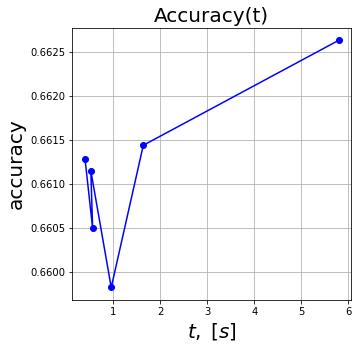

In [93]:
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)
plt.grid(True)
plt.title('Accuracy(t)', fontsize=20)
plt.plot(time[:-1], accuracy[:-1], 'b-o')
plt.xlabel(r'$t,\;[s]$', fontsize=20)
plt.ylabel('accuracy', fontsize=20)

In [54]:
time

[5.790385299999798,
 1.6357598999998118,
 0.9539253999996617,
 0.5196601000002374,
 0.5583888999999544,
 0.39612510000006296,
 18.950620300000082]

In [55]:
accuracy

[0.6626265342578898,
 0.6614356235953978,
 0.6598221317300859,
 0.6611475000480206,
 0.6604944200072991,
 0.6612819577034632,
 0.6577668504254625]

Получаем, что при возрастании параметра $alpha$ до $0.5$ время работы алгоритма уменьшается и accuracy увеличивается.